In [52]:
import pandas as pd
import os
from collections import defaultdict
import numpy as np

df = pd.read_csv('results/feature_vector.csv', index_col=0)
labels = df['label']
df.drop('label', axis=1, inplace=True)

In [49]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0, criterion='entropy')
cross_val_score(clf, df, labels, cv=10)

array([0.6, 1. , 0.6, 0.8, 0.8, 0.6, 0.6, 0.8, 1. , 1. ])

[Text(0.5769230769230769, 0.9, 'AU04_mean <= 0.329\nentropy = 2.322\nsamples = 50\nvalue = [10, 10, 10, 10, 10]\nclass = angry'),
 Text(0.3076923076923077, 0.7, 'AU06_e2_intensity <= 0.395\nentropy = 1.741\nsamples = 30\nvalue = [0, 9, 10, 10, 1]\nclass = happy'),
 Text(0.15384615384615385, 0.5, 'AU07_e2_length <= 11.083\nentropy = 1.245\nsamples = 19\nvalue = [0, 9, 0, 9, 1]\nclass = fear'),
 Text(0.07692307692307693, 0.3, 'entropy = 0.0\nsamples = 9\nvalue = [0, 9, 0, 0, 0]\nclass = fear'),
 Text(0.23076923076923078, 0.3, 'AU01_mean <= 0.102\nentropy = 0.469\nsamples = 10\nvalue = [0, 0, 0, 9, 1]\nclass = neutral'),
 Text(0.15384615384615385, 0.1, 'entropy = 0.0\nsamples = 1\nvalue = [0, 0, 0, 0, 1]\nclass = sad'),
 Text(0.3076923076923077, 0.1, 'entropy = 0.0\nsamples = 9\nvalue = [0, 0, 0, 9, 0]\nclass = neutral'),
 Text(0.46153846153846156, 0.5, 'AU06_e0_length <= 38.0\nentropy = 0.439\nsamples = 11\nvalue = [0, 0, 10, 1, 0]\nclass = happy'),
 Text(0.38461538461538464, 0.3, 'entro

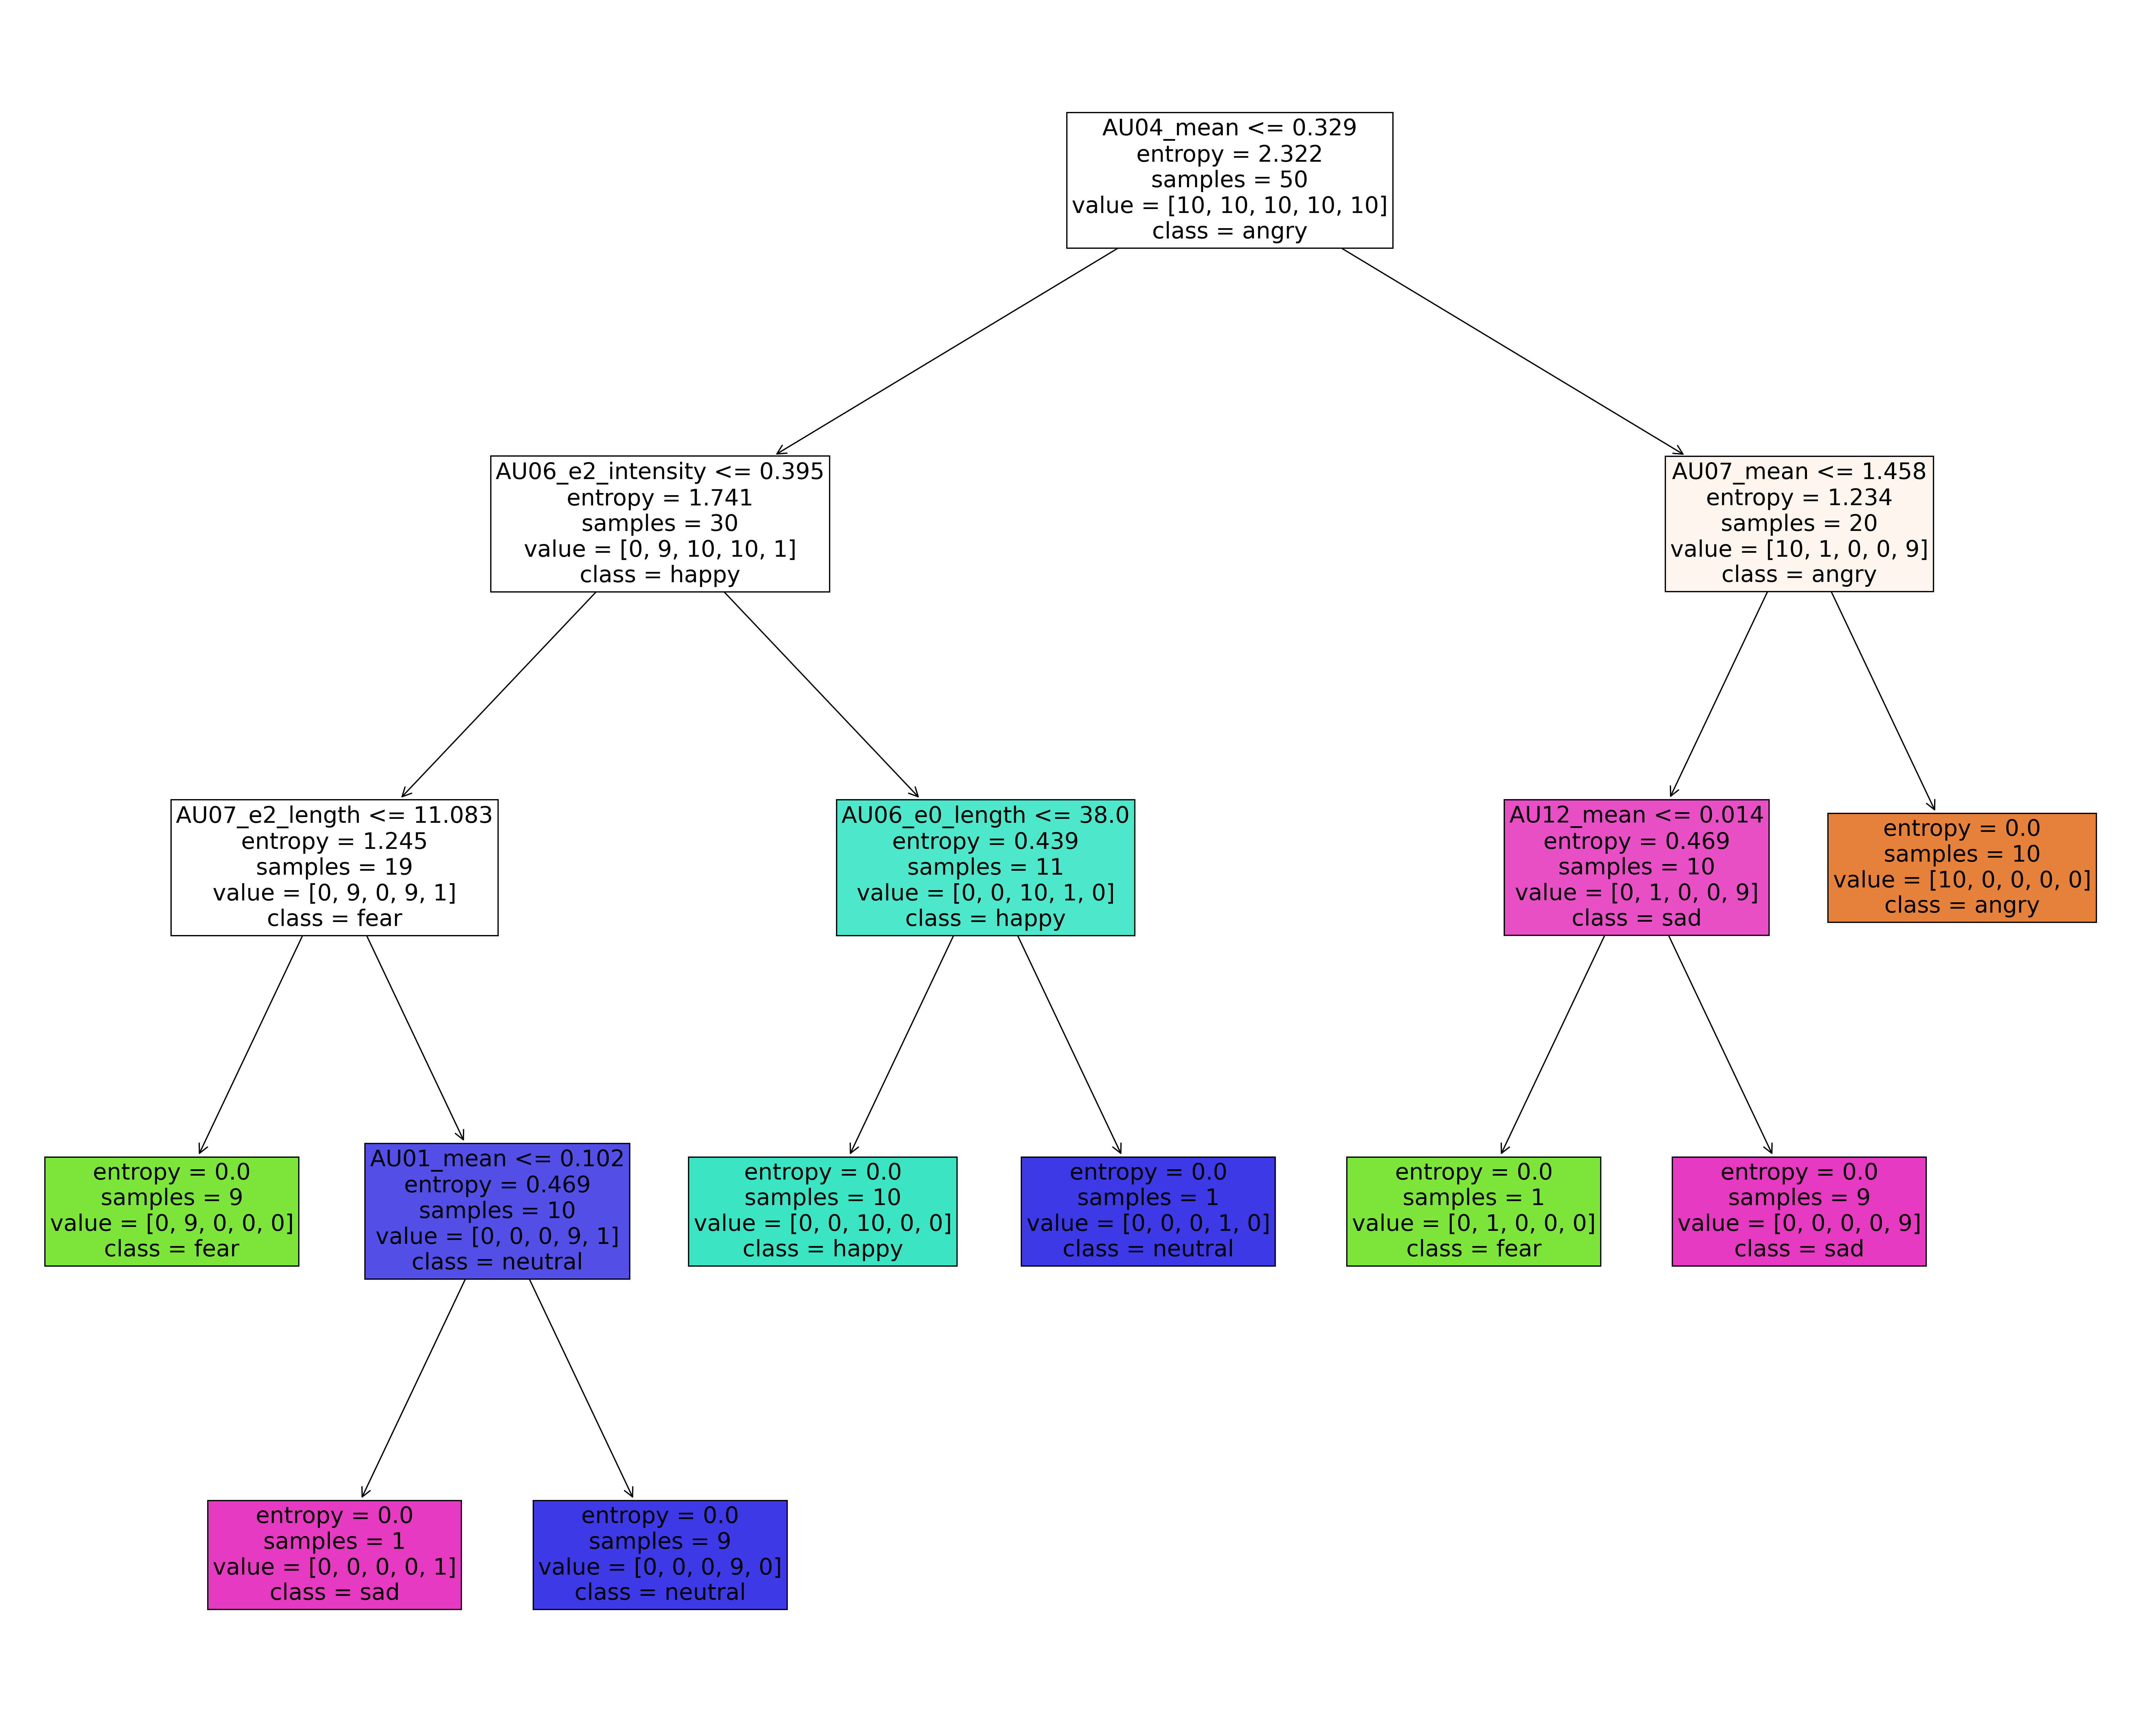

In [51]:
import matplotlib.pyplot as plt
clf.fit(df, labels)

fig = plt.figure(figsize=(30,25), dpi=300)
tree.plot_tree(clf, filled=True, fontsize = 18, feature_names = df.columns.tolist(),
               class_names=['angry','fear','happy', 'neutral', 'sad'])
# plt.savefig('out.jpeg')
